In [79]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [58]:
def generate_wave_data(num_samples=1000, seq_length=100, noise=0.1):
    data = []
    t = np.linspace(0, 4*np.pi, seq_length)

    for _ in range(num_samples):
        sine = np.sin(t) + noise * np.random.randn(seq_length)
        cosine = np.cos(t) + noise * np.random.randn(seq_length)

        sample = np.stack([sine, cosine], axis=1)
        data.append(sample)

    data = np.array(data)
    return data

In [62]:
# generate toy data  
data = generate_wave_data()

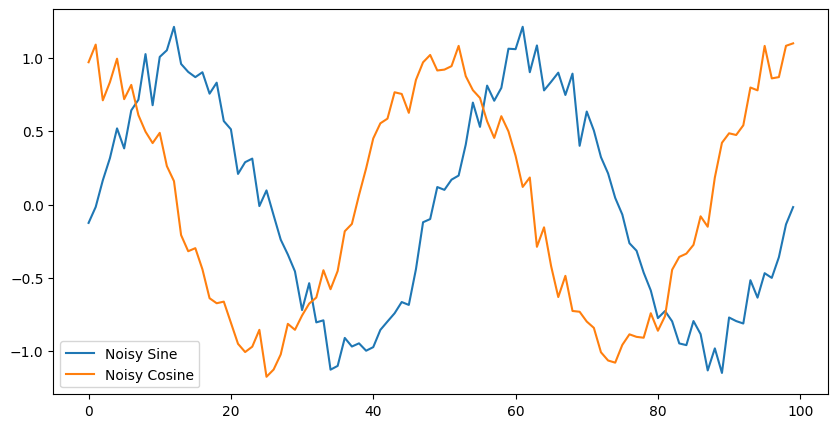

In [65]:
# plot a sample to inspect the level of noise 
s = 35 
plt.figure(figsize=(10, 5))
plt.plot(data[s, :, 0], label="Noisy Sine")
plt.plot(data[s, :, 1], label="Noisy Cosine")
plt.legend()
plt.show()

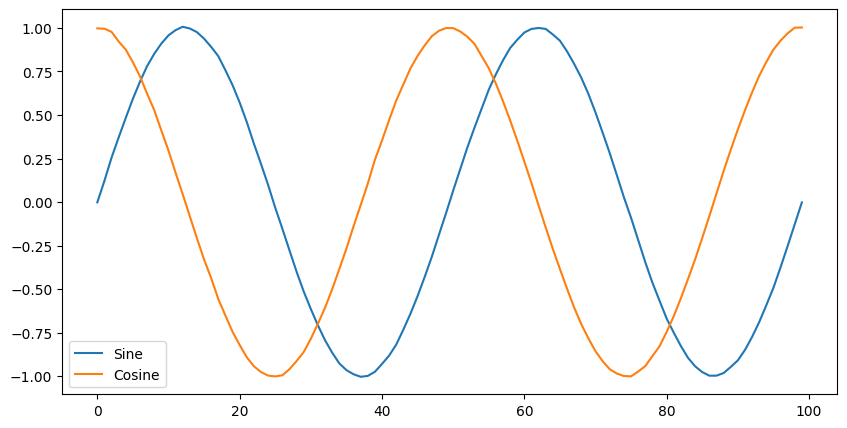

In [64]:
# plot the average to see that the clean signal can be recovered 
data_avg = np.mean(data, axis=0) 
plt.figure(figsize=(10, 5))
plt.plot(data_avg[:, 0], label="Sine")
plt.plot(data_avg[:, 1], label="Cosine")
plt.legend()
plt.show()

In [73]:
def split_data(data, test_size=0.2, random_state=None):
    X_train, y = train_test_split(data, test_size=test_size, random_state=random_state)
    return X_train, y

In [74]:
# split the data into training and test set 
X_train, y = split_data(data, random_state=42)

In [82]:
def create_data_loaders(X_train, X_test, batch_size=16, shuffle=True):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

In [119]:
# batch the data 
train_loader, test_loader = create_data_loaders(X_train, y)

In [116]:
def split_past_future(batch, num_future_points=10):
    past_values = batch[:, :-num_future_points, :]
    future_values = batch[:, -num_future_points:, :]
    return past_values, future_values

def store_past_future_batches(data_loader, num_future_points=10):
    all_past_values = []
    all_future_values = []

    for batch in data_loader:
        past_values, future_values = split_past_future(batch[0], num_future_points)
        all_past_values.append(past_values)
        all_future_values.append(future_values)

    all_past_values = torch.stack(all_past_values)
    all_future_values = torch.stack(all_future_values)
    
    return all_past_values, all_future_values

In [120]:
# divide the data into past and future time points 
past_values, future_values= store_past_future_batches(train_loader)

In [122]:
# define the configuration of the model 
config = TimeSeriesTransformerConfig(
    prediction_length=10,  # length of the future values to predict
    context_length=89,  # length of the past values to use
    num_time_features=1, # number of time features
    encoder_layers=2,  # number of transformer layers in the encoder
    decoder_layers=2,  # number of transformer layers in the decoder
    d_model=32,  # dimension of the model
    n_heads=4,  # number of attention heads
    input_size=2, # size of the input 
    lags_sequence=[1], # sequence of lags 
    )

# initialize the model 
model = TimeSeriesTransformerForPrediction(config)

In [6]:
# Modified batch with correct dimensions
batch = {
    "past_values": past_values.unsqueeze(0),  # (batch_size, seq_length, input_size)
    "future_values": future_values.unsqueeze(0),  # (batch_size, prediction_length, input_length)
    "past_time_features": torch.arange(len(past_values)).unsqueeze(0).unsqueeze(2).float(),  # (1, seq_length, 1)
    "past_observed_mask": torch.ones_like(past_values).unsqueeze(0),  # (1, seq_length, input_size)
    "future_time_features": torch.arange(len(past_values), len(past_values) + 10).unsqueeze(0).unsqueeze(2).float(),  # (1, prediction_length, 1)
}


In [38]:
# Initialize optimizer
optim = Adam(model.parameters(), lr=1e-3)

# Define training loop 
num_epochs = 100 

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(
        past_values=batch["past_values"],
        past_time_features=batch["past_time_features"],
        past_observed_mask=batch["past_observed_mask"],
        future_values=batch["future_values"],
        future_time_features=batch["future_time_features"],
    )

    loss = outputs.loss

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 0.2433
Epoch 2/100, Loss: 0.2982
Epoch 3/100, Loss: 0.2486
Epoch 4/100, Loss: 0.1577
Epoch 5/100, Loss: 0.1907
Epoch 6/100, Loss: 0.1955
Epoch 7/100, Loss: 0.1349
Epoch 8/100, Loss: 0.2048
Epoch 9/100, Loss: 0.0180
Epoch 10/100, Loss: 0.1248
Epoch 11/100, Loss: -0.1826
Epoch 12/100, Loss: 0.0163
Epoch 13/100, Loss: 0.1119
Epoch 14/100, Loss: -0.1069
Epoch 15/100, Loss: -0.0098
Epoch 16/100, Loss: -0.1135
Epoch 17/100, Loss: -0.1970
Epoch 18/100, Loss: -0.1940
Epoch 19/100, Loss: -0.3098
Epoch 20/100, Loss: -0.1105
Epoch 21/100, Loss: -0.3084
Epoch 22/100, Loss: -0.5852
Epoch 23/100, Loss: -0.3239
Epoch 24/100, Loss: -0.4999
Epoch 25/100, Loss: -0.5849
Epoch 26/100, Loss: -0.3144
Epoch 27/100, Loss: -0.4796
Epoch 28/100, Loss: -0.6871
Epoch 29/100, Loss: -0.6705
Epoch 30/100, Loss: -0.6995
Epoch 31/100, Loss: -0.7518
Epoch 32/100, Loss: -0.8722
Epoch 33/100, Loss: -0.4392
Epoch 34/100, Loss: -0.9879
Epoch 35/100, Loss: -0.8544
Epoch 36/100, Loss: -0.4541
Epoch 37/100,

In [41]:
# evaluate the model 
model.eval()

with torch.no_grad():
    predictions=model.generate(
        past_values=batch["past_values"],
        past_time_features=batch["past_time_features"],
        future_time_features=batch["future_time_features"], 
        past_observed_mask=batch["past_observed_mask"]
    )


# remove batch dimension of predictions 
predicted_values = predictions.sequences[:, :, :, :].squeeze(0).numpy()

In [43]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [54]:
# get the best predictions from the 100 different predictions 
target_sine = data[-10:, 0]
target_cosine = data[-10:, 1]
mse_cosine_lst  = []
mse_sine_lst = []
mse = []

for i in range(predicted_values.shape[0]):
    mse_sine = mean_squared_error(target_sine, predicted_values[i, :, 0])
    mse_cosine = mean_squared_error(target_sine, predicted_values[i, :, 1])
    mse_sine_lst.append(mse_sine)
    mse_cosine_lst.append(mse_cosine)

    mse.append(np.mean(mse_sine + mse_cosine))

In [55]:
best_pred = np.argmin(np.array(mse))
best_pred_sine = np.argmin(np.array(mse_sine_lst))
best_pred_cosine = np.argmin(np.array(mse_cosine_lst))

In [56]:
best_pred, best_pred_sine, best_pred_cosine

(24, 57, 24)

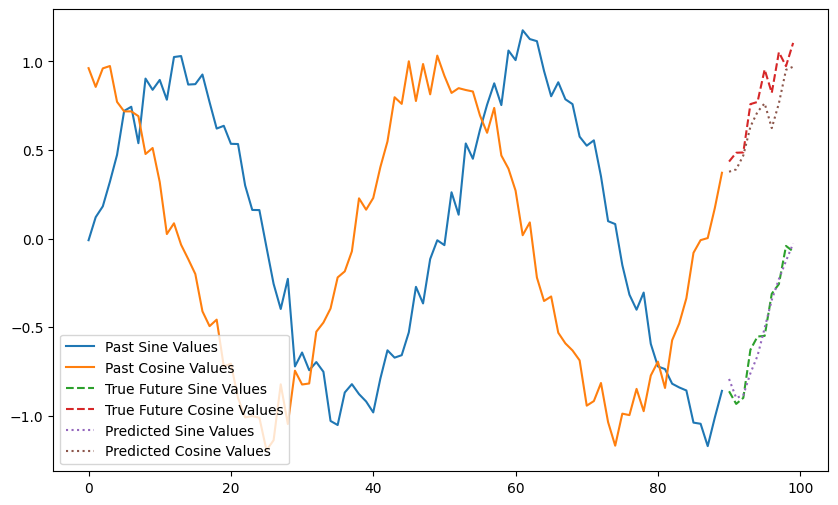

In [57]:
# Plot the best predictions
plt.figure(figsize=(10, 6))

# Plot past values
plt.plot(np.arange(len(past_values)), past_values.numpy()[:, 0], label="Past Sine Values")
plt.plot(np.arange(len(past_values)), past_values.numpy()[:, 1], label="Past Cosine Values")

# Plot true future values
plt.plot(np.arange(len(past_values), len(past_values) + 10), future_values.numpy()[:, 0], label="True Future Sine Values", linestyle='dashed')
plt.plot(np.arange(len(past_values), len(past_values) + 10), future_values.numpy()[:, 1], label="True Future Cosine Values", linestyle='dashed')

# Plot predicted future values
plt.plot(np.arange(len(past_values), len(past_values) + 10), predicted_values[best_pred_sine, :, 0], label="Predicted Sine Values", linestyle='dotted')
plt.plot(np.arange(len(past_values), len(past_values) + 10), predicted_values[best_pred_cosine, :, 1], label="Predicted Cosine Values", linestyle='dotted')

plt.legend()
plt.show()
